In [1]:
import tensorflow as tf, matplotlib.pyplot as plt, numpy as np
from LoadCifar import read_and_decode_single_cifar10, unpickle, cPickle

%matplotlib inline

sess = tf.InteractiveSession()

batch_size = 50

label, image = read_and_decode_single_cifar10("cifar10.tfrecords", None)
y_batch, x_batch = tf.train.shuffle_batch([label, image], batch_size=batch_size, capacity=50000, min_after_dequeue=1000)

label_test, image_test = read_and_decode_single_cifar10("cifar10_test.tfrecords", None)
y_t, x_t = tf.train.batch([label_test, image_test], batch_size=10000, capacity=10000)
label_names = unpickle('cifar10/batches.meta')['label_names']

In [2]:
# Helper functions
def weight(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))
def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))
def conv_layer(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')
def max_pool_layer(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

def conv_relu_pool_norm_layer(x, W, b):
    conv = conv_layer(x, W)
    relu = tf.nn.relu(conv+b)
    pool = max_pool_layer(relu)
    norm = tf.nn.lrn(pool, 4, bias=1.0, alpha=0.001/9.0, beta=0.75)
    return norm

In [3]:
# Build Compute Graph

x = tf.placeholder(tf.float32, shape=[None,32,32,3])
y = tf.placeholder(tf.float32, shape=[None,10])
do = tf.placeholder(tf.float32)
reg = tf.placeholder(tf.float32)

Wc1 = weight([5,5,3,64]); b1 = bias([64])
conv1 = conv_relu_pool_norm_layer(x, Wc1, b1)

Wc2 = weight([5,5,64,64]); b2 = bias([64])
conv2 = conv_relu_pool_norm_layer(conv1, Wc2, b2)


x_reflat = tf.reshape(conv2, [-1, 8*8*64])

Wk1 = weight([8*8*64, 384]); bk1 = bias([384])
k1 = tf.nn.relu(tf.matmul(x_reflat, Wk1)+bk1)

Wk2 = weight([384, 192]); bk2 = bias([192])
k2 = tf.nn.relu(tf.matmul(k1, Wk2)+bk2)

dropout = tf.nn.dropout(k2, do)

Wk3 = weight([192, 10]); bk3 = bias([10])
k3 = tf.matmul(dropout, Wk3)+bk3

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(k3, y))
loss = cross_entropy + reg*(tf.nn.l2_loss(Wc1) + tf.nn.l2_loss(Wc2) + tf.nn.l2_loss(Wk1) + tf.nn.l2_loss(Wk2) + tf.nn.l2_loss(Wk3)) 

# Defining the accuracy
correct_prediction = tf.equal(tf.argmax(k3,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [4]:
# Optimization
global_step = tf.Variable(0, trainable=False)
lr = tf.train.exponential_decay(5e-4, global_step, 500, 0.97, staircase=True)
train_step = tf.train.AdamOptimizer(lr).minimize(loss, global_step=global_step)

init = tf.initialize_all_variables()
sess.run(init)
tf.train.start_queue_runners(sess=sess)

[<Thread(Thread-4, started daemon 140640261453568)>,
 <Thread(Thread-5, started daemon 140639993169664)>,
 <Thread(Thread-6, started daemon 140639576520448)>,
 <Thread(Thread-7, started daemon 140639568127744)>]

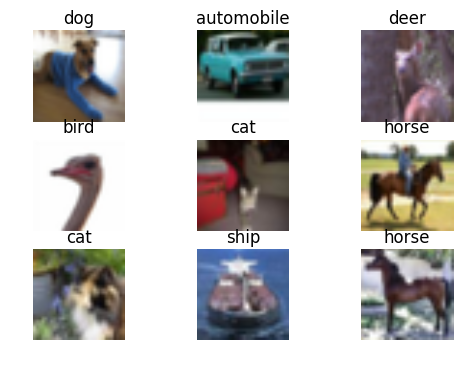

In [5]:
y_sample, x_sample = sess.run([y_batch, x_batch])

fig = plt.figure()
for i in range(9):
    ax = fig.add_subplot(3,3,i+1); ax.axis('off')
    img = np.array(x_sample[i], dtype='float32')
    ax.set_title(label_names[np.argmax(y_sample[i])])
    ax.imshow(img)

plt.show()

In [6]:
# Training
y_test, x_test = sess.run([y_t, x_t])
for i in range(20000):
    y_sample, x_sample = sess.run([y_batch, x_batch])

    sess.run(train_step, feed_dict={x: x_sample, y: y_sample, do: 0.5, reg: 0.002})
    if i % 500 == 0:
        y_sample, x_sample = sess.run([y_batch, x_batch])
        train_acc = accuracy.eval(session=sess, feed_dict={x: x_sample, y: y_sample, do: 1.0})
        test_acc = accuracy.eval(session=sess, feed_dict={x: x_test, y: y_test, do: 1.0})
        print "[", i, "] train: ", train_acc, ", test: ", test_acc,", alpha: ", sess.run(lr)
        
sess.close()

(10000, 10) (10000, 32, 32, 3)
[ 0 ] train:  0.18 , test:  0.0989 , alpha:  0.0005
[ 500 ] train:  0.52 , test:  0.4218 , alpha:  0.000485
[ 1000 ] train:  0.56 , test:  0.4743 , alpha:  0.00047045
[ 1500 ] train:  0.66 , test:  0.5659 , alpha:  0.000456337
[ 2000 ] train:  0.66 , test:  0.5972 , alpha:  0.000442646
[ 2500 ] train:  0.66 , test:  0.6283 , alpha:  0.000429367
[ 3000 ] train:  0.64 , test:  0.6445 , alpha:  0.000416486
[ 3500 ] train:  0.66 , test:  0.6534 , alpha:  0.000403992
[ 4000 ] train:  0.76 , test:  0.6689 , alpha:  0.000391872
[ 4500 ] train:  0.78 , test:  0.6677 , alpha:  0.000380116
[ 5000 ] train:  0.76 , test:  0.6877 , alpha:  0.000368712
[ 5500 ] train:  0.76 , test:  0.6852 , alpha:  0.000357651
[ 6000 ] train:  0.68 , test:  0.6853 , alpha:  0.000346921
[ 6500 ] train:  0.72 , test:  0.7091 , alpha:  0.000336514
[ 7000 ] train:  0.78 , test:  0.7109 , alpha:  0.000326418
[ 7500 ] train:  0.72 , test:  0.7149 , alpha:  0.000316626
[ 8000 ] train:  0.76 

ERROR:tensorflow:Exception in QueueRunner: Attempted to use a closed Session.
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/usr/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/training/queue_runner.py", line 225, in _run
    sess.run(enqueue_op)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 717, in run
    run_metadata_ptr)
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/client/session.py", line 853, in _run
    raise RuntimeError('Attempted to use a closed Session.')
RuntimeError: Attempted to use a closed Session.

ERROR:tensorflow:Exception in QueueRunner: Enqueue operation was cancelled
	 [[Node: input_producer_1/input_producer_1_EnqueueMany = QueueEnqueueMany[Tcomponents=[DT_STRING], _class=["loc: